In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os, sys, seaborn as sns
churndata = pd.read_pickle('churndata.pkl')
churndata.head().T

,0,1,2,3,4
id,8779-QRDMV,7495-OOKFY,1658-BYGOY,4598-XLKNJ,4846-WHAFZ
months,1,8,18,25,37
offer,None,Offer E,Offer D,Offer C,Offer C
phone,No,Yes,Yes,Yes,Yes
multiple,No,Yes,Yes,No,Yes
internet_type,DSL,Fiber Optic,Fiber Optic,Fiber Optic,Fiber Optic
gb_mon,8,17,52,12,14
security,No,No,No,No,No
backup,No,Yes,No,Yes,No
protection,Yes,No,No,Yes,No


In [2]:
churndata.shape
churndata.dtypes
churndata.dtypes.value_counts()

object     13
int64       6
float64     2
dtype: int64

In [3]:
from colorsetup import colors, palette
sns.set_palette(palette)

In [4]:
churndata.columns

Index(['id', 'months', 'offer', 'phone', 'multiple', 'internet_type', 'gb_mon',
       'security', 'backup', 'protection', 'support', 'unlimited', 'contract',
       'paperless', 'payment', 'monthly', 'total_revenue', 'satisfaction',
       'churn_value', 'churn_score', 'cltv'],
      dtype='object')

In [5]:
df = churndata.drop(columns=['id', 'phone', 'total_revenue', 'cltv', 'churn_score'])

In [6]:
df.describe(include='object')

,offer,multiple,internet_type,security,backup,protection,support,unlimited,contract,paperless,payment
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,6,2,4,2,2,2,2,2,3,2,3
top,None,No,Fiber Optic,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal
freq,3877,4072,3035,5024,4614,4621,4999,4745,3610,4171,3909


In [7]:
### BEGIN SOLUTION
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

,Unique Values
Variable,
months,72
offer,6
multiple,2
internet_type,4
gb_mon,50
security,2
backup,2
protection,2
support,2


In [8]:
#binary variables:
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_variables

['multiple',
 'security',
 'backup',
 'protection',
 'support',
 'unlimited',
 'paperless',
 'churn_value']

In [9]:
categorical_variables = list(df_uniques[(6 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
categorical_variables

['offer', 'internet_type', 'contract', 'payment', 'satisfaction']

In [10]:
ordinal_variables = ['contract', 'satisfaction']
ordinal_variables.append('months')

In [11]:
ordinal_variables

['contract', 'satisfaction', 'months']

In [12]:
numeric_variables = list(set(df.columns) - set(ordinal_variables) - set(categorical_variables) - set(binary_variables))

In [13]:
numeric_variables

['gb_mon', 'monthly']

In [14]:
#transform month into  5 intervals
df['months'] = pd.cut(df['months'], bins=5)

array([[<AxesSubplot:title={'center':'gb_mon'}>,
        <AxesSubplot:title={'center':'monthly'}>]], dtype=object)

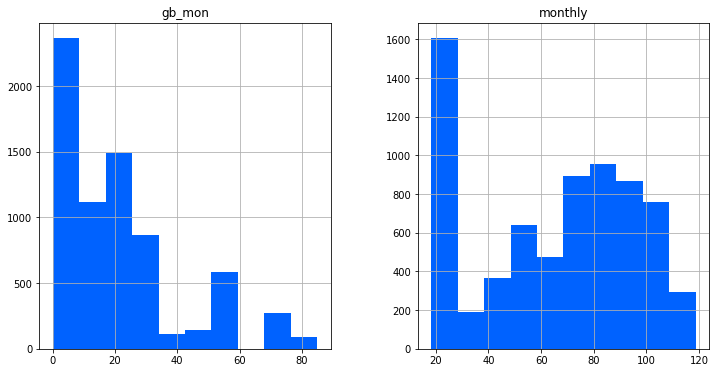

In [15]:
df[numeric_variables].hist(color=colors[0], figsize=(12, 6))

In [16]:
df['months'].unique()

[(0.929, 15.2], (15.2, 29.4], (29.4, 43.6], (57.8, 72.0], (43.6, 57.8]]
Categories (5, interval[float64]): [(0.929, 15.2] < (15.2, 29.4] < (29.4, 43.6] < (43.6, 57.8] < (57.8, 72.0]]

In [17]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder
label_binarizer, label_encoder = LabelBinarizer(), LabelEncoder()

In [18]:
for column in ordinal_variables:
    df[column] = label_encoder.fit_transform(df[column])

In [19]:
for column in binary_variables:
    df[column] = label_binarizer.fit_transform(df[column])

In [20]:
categorical_variables

['offer', 'internet_type', 'contract', 'payment', 'satisfaction']

In [21]:
categorical_variables = list(set(categorical_variables) - set(ordinal_variables))

In [22]:
categorical_variables

['internet_type', 'payment', 'offer']

In [23]:
df = pd.get_dummies(df, columns = categorical_variables, drop_first=True)

In [24]:
df.shape

(7043, 23)

In [25]:
from sklearn.preprocessing import MinMaxScaler
minMax_Scaler = MinMaxScaler()

In [26]:
for column in [ordinal_variables + numeric_variables]:
    df[column] = minMax_Scaler.fit_transform(df[column])

In [27]:
# END OF EDA

In [28]:
### BEGIN SOLUTION
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

y, X = df['churn_value'], df.drop(columns='churn_value')

In [29]:
corr_values = X.corr()

In [30]:
churn_value_correlation = df.corr()['churn_value']
churn_value_correlation

months                      -0.337205
multiple                     0.040102
gb_mon                       0.048868
security                    -0.171226
backup                      -0.082255
protection                  -0.066160
support                     -0.164674
unlimited                    0.166545
contract                    -0.435398
paperless                    0.191825
monthly                      0.193356
satisfaction                -0.754649
churn_value                  1.000000
internet_type_DSL           -0.099716
internet_type_Fiber Optic    0.279623
internet_type_None          -0.227890
payment_Credit Card         -0.218528
payment_Mailed Check         0.056348
offer_Offer A               -0.126654
offer_Offer B               -0.117723
offer_Offer C               -0.020660
offer_Offer D                0.001435
offer_Offer E                0.214648
Name: churn_value, dtype: float64

<AxesSubplot:>

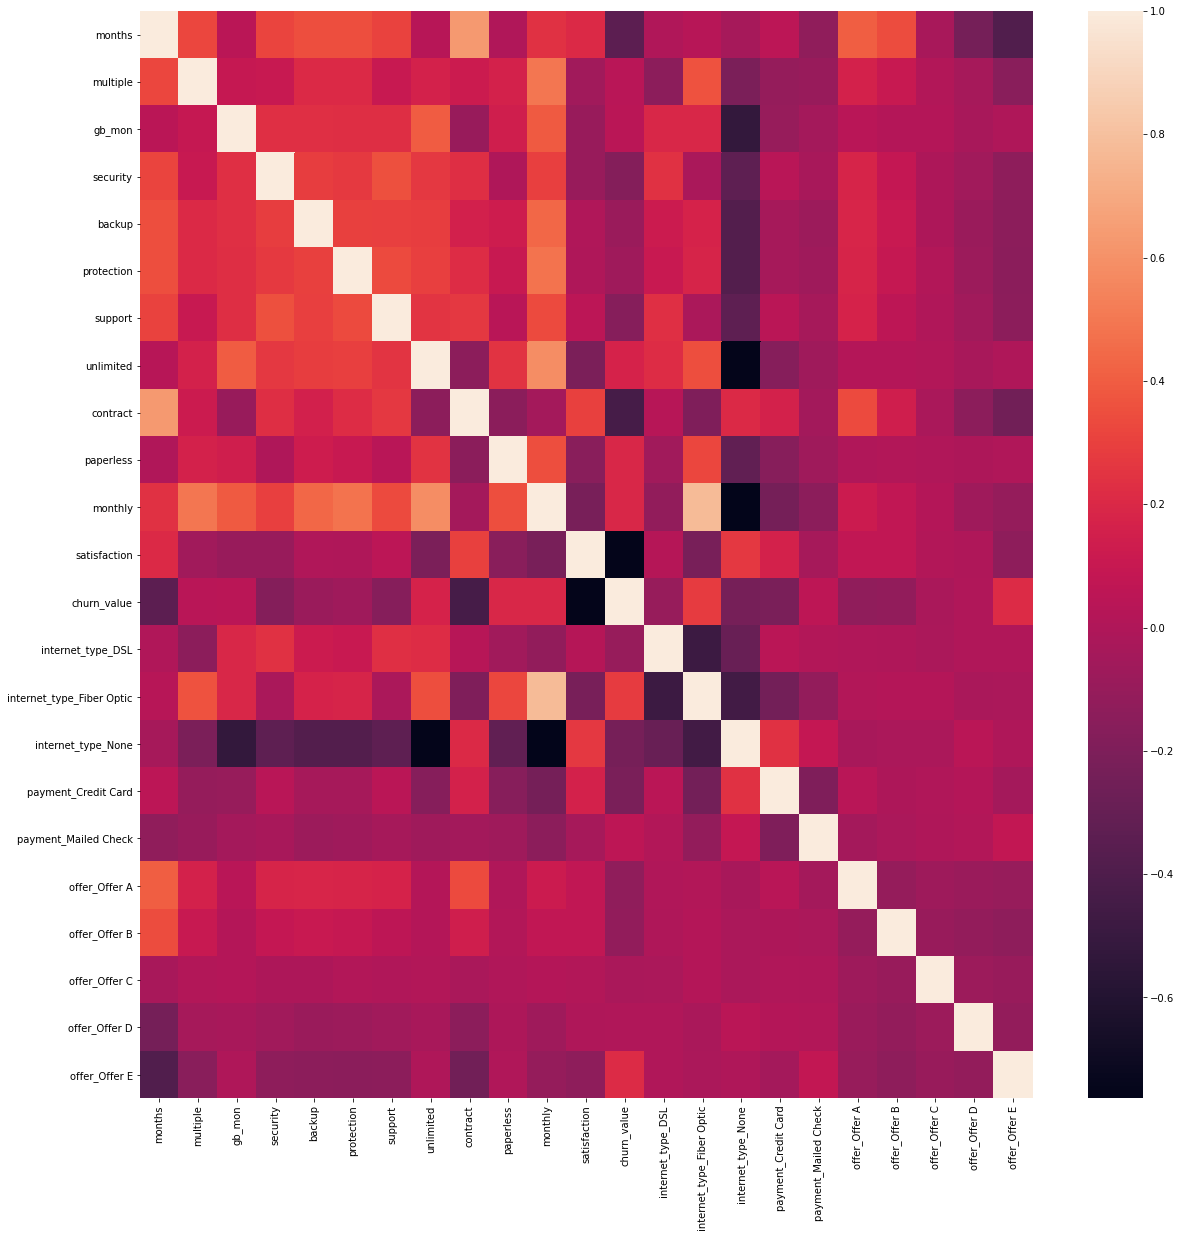

In [31]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(df.corr())

In [32]:
churn_value_correlation.sort_values()

satisfaction                -0.754649
contract                    -0.435398
months                      -0.337205
internet_type_None          -0.227890
payment_Credit Card         -0.218528
security                    -0.171226
support                     -0.164674
offer_Offer A               -0.126654
offer_Offer B               -0.117723
internet_type_DSL           -0.099716
backup                      -0.082255
protection                  -0.066160
offer_Offer C               -0.020660
offer_Offer D                0.001435
multiple                     0.040102
gb_mon                       0.048868
payment_Mailed Check         0.056348
unlimited                    0.166545
paperless                    0.191825
monthly                      0.193356
offer_Offer E                0.214648
internet_type_Fiber Optic    0.279623
churn_value                  1.000000
Name: churn_value, dtype: float64

[(-1.0, 1.0), Text(0, 0.5, 'correlation')]

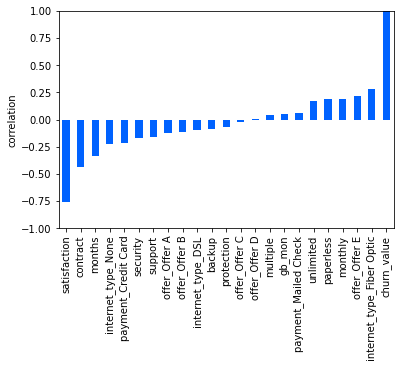

In [33]:
ax = churn_value_correlation.sort_values().plot(kind='bar')
ax.set(ylim=[-1, 1], ylabel='correlation')

In [34]:
y.value_counts(normalize=True)

0    0.73463
1    0.26537
Name: churn_value, dtype: float64

In [35]:
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(X, y))
# Create the dataframes
X_train = X.loc[train_idx]
y_train = y.loc[train_idx]

X_test  = X.loc[test_idx]
y_test  = y.loc[test_idx]

In [36]:
y_train.shape

(4930,)

In [37]:
# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_lr_predict = lr.predict(X_test)

In [38]:
print(classification_report(y_test, y_lr_predict))
print('Accuracy score: ', round(accuracy_score(y_test, y_lr_predict), 2))
print('F1 Score: ', round(f1_score(y_test, y_lr_predict), 2))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1552
           1       0.96      0.85      0.90       561

    accuracy                           0.95      2113
   macro avg       0.95      0.92      0.93      2113
weighted avg       0.95      0.95      0.95      2113

Accuracy score:  0.95
F1 Score:  0.9


In [39]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=5)
knn = knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_knn_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_knn_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_knn_pred), 2))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1552
           1       0.81      0.73      0.77       561

    accuracy                           0.88      2113
   macro avg       0.86      0.83      0.84      2113
weighted avg       0.88      0.88      0.88      2113

Accuracy score:  0.88
F1 Score:  0.77


In [40]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_knn_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_knn_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_knn_pred), 2))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1552
           1       0.77      0.73      0.75       561

    accuracy                           0.87      2113
   macro avg       0.84      0.82      0.83      2113
weighted avg       0.87      0.87      0.87      2113

Accuracy score:  0.87
F1 Score:  0.75


In [41]:
### BEGIN SOLUTION
max_k = 40
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

Text(0.5, 1.0, 'KNN Elbow Curve')

<Figure size 1800x1200 with 0 Axes>

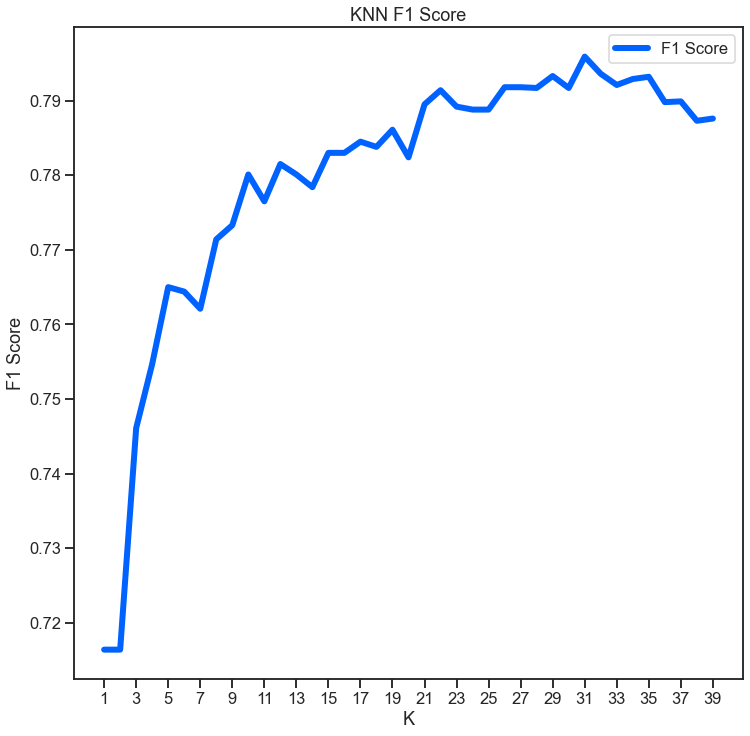

<Figure size 1800x1200 with 0 Axes>

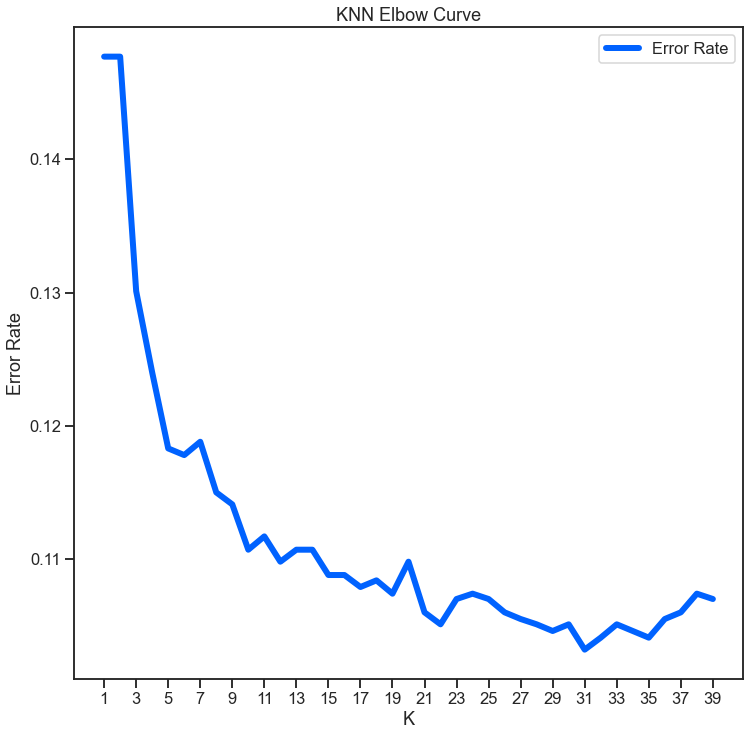

In [42]:
# Plot F1 results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(color=colors[0], figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')


# Plot Accuracy (Error Rate) results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot(color=colors[0], figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')
### END SOLUTION

In [43]:
f1_results

,K,F1 Score
0,1,0.7164
1,2,0.7164
2,3,0.7461
3,4,0.7547
4,5,0.7650
5,6,0.7644
6,7,0.7621
7,8,0.7714
8,9,0.7733
9,10,0.7801


In [44]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=30)
knn = knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_knn_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_knn_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_knn_pred), 2))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1552
           1       0.83      0.71      0.77       561

    accuracy                           0.89      2113
   macro avg       0.87      0.83      0.85      2113
weighted avg       0.88      0.89      0.88      2113

Accuracy score:  0.89
F1 Score:  0.77


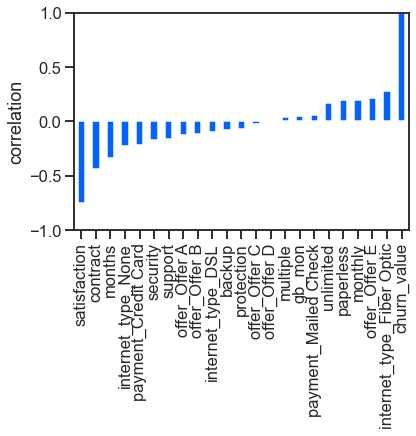

In [45]:
ax = churn_value_correlation.sort_values().plot(kind='bar', color=colors[0])
ax.set(ylim=[-1, 1], ylabel='correlation');

In [46]:
from sklearn.svm import LinearSVC

LSVC = LinearSVC()
LSVC.fit(X_train, y_train)
y_LSVC_pred = LSVC.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_LSVC_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_LSVC_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_LSVC_pred), 2))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1552
           1       0.96      0.85      0.90       561

    accuracy                           0.95      2113
   macro avg       0.95      0.92      0.93      2113
weighted avg       0.95      0.95      0.95      2113

Accuracy score:  0.95
F1 Score:  0.9


In [47]:
from sklearn.svm import SVC

gammas = [.5, 1, 2, 10]
for gamma in gammas:
    SVC_Gaussian = SVC(kernel='rbf', gamma=gamma)
    SVC_Gaussian.fit(X_train, y_train)
    y_SVC_predict = SVC_Gaussian.predict(X_test)
    print('gamma = ' ,gamma)
    print('Accuracy score: ', round(accuracy_score(y_test, y_SVC_predict), 2))
    print('F1 Score: ', round(f1_score(y_test, y_SVC_predict), 2))

gamma =  0.5
Accuracy score:  0.94
F1 Score:  0.88
gamma =  1
Accuracy score:  0.92
F1 Score:  0.85
gamma =  2
Accuracy score:  0.88
F1 Score:  0.74
gamma =  10
Accuracy score:  0.83
F1 Score:  0.56


In [48]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)
y_dt_pred = dt.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_dt_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_dt_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_dt_pred), 2))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1552
           1       0.85      0.86      0.86       561

    accuracy                           0.92      2113
   macro avg       0.90      0.90      0.90      2113
weighted avg       0.92      0.92      0.92      2113

Accuracy score:  0.92
F1 Score:  0.86


In [49]:
### BEGIN SOLUTION
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(53, 7)

In [50]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(53, 7)

In [51]:
dt.tree_.node_count

543

In [52]:
y_GR_pred = GR.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_GR_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_GR_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_GR_pred), 2))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1552
           1       0.92      0.84      0.88       561

    accuracy                           0.94      2113
   macro avg       0.93      0.91      0.92      2113
weighted avg       0.94      0.94      0.94      2113

Accuracy score:  0.94
F1 Score:  0.88


In [53]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()
# Iterate through all of the possibilities for 
# number of trees
for n_trees in [30, 40, 50, 100, 150, 200, 300, 400 ,500 ,600]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

,oob
n_trees,
30.0,0.050710
40.0,0.048479
50.0,0.047465
100.0,0.047262
150.0,0.046653
200.0,0.048073
300.0,0.048479
400.0,0.047262
500.0,0.047465


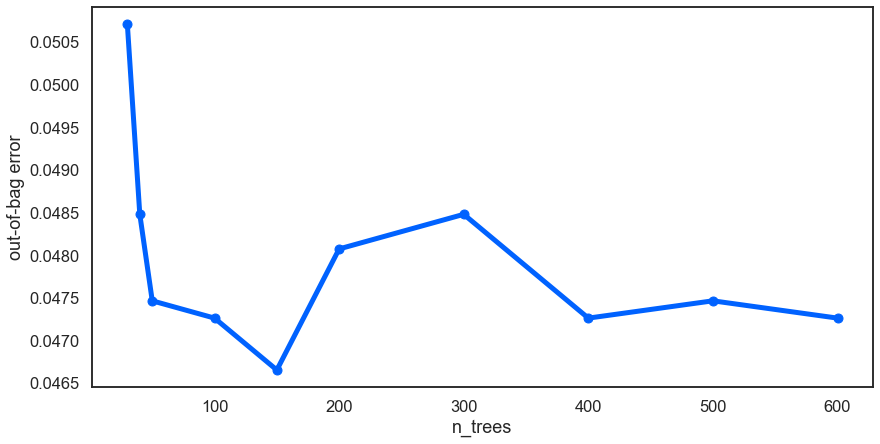

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

NameError: name 'model' is not defined

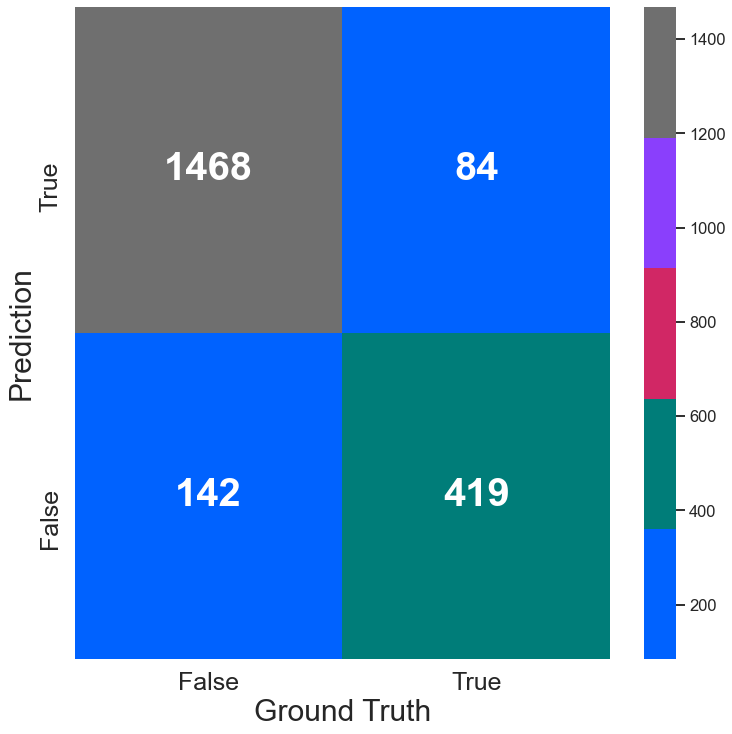

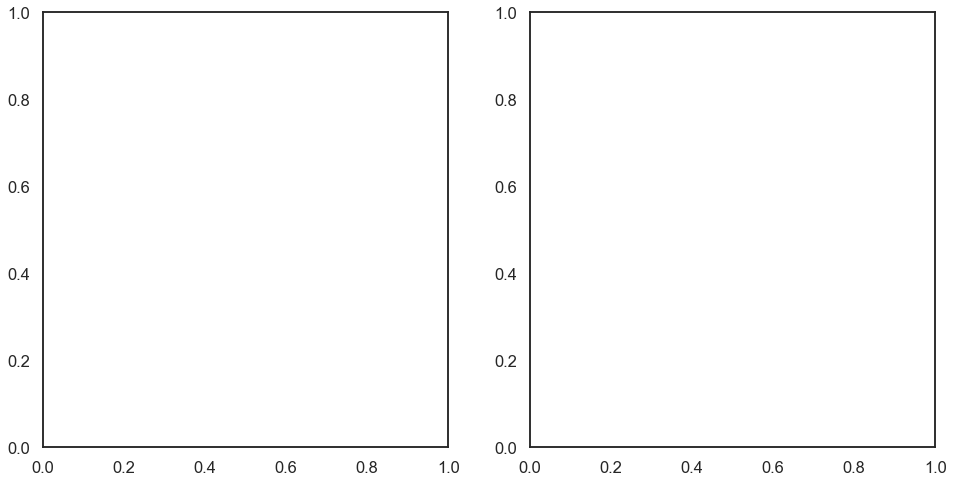

In [55]:
#confusion matrix
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap=colors, annot_kws={"size": 40, "weight": "bold"})

labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)


#the ROC-AUC curve
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)

# Get the probabilities for each of the two categories
y_prob = model.predict_proba(X_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr, color=colors[0], linewidth=5)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision, color=colors[1], linewidth=5)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

feature_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar', figsize=(16, 6))
ax.set(ylabel='Relative Importance');
ax.set(ylabel='Feature');

model is : LogisticRegression(solver='liblinear')
model is : KNeighborsClassifier(n_neighbors=30)
model is : LinearSVC()
model is : DecisionTreeClassifier(random_state=42)
model is : GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 21, 2),
                         'max_features': range(1, 23)},
             scoring='accuracy')
model is : RandomForestClassifier(n_estimators=600, n_jobs=-1, oob_score=True,
                       random_state=42, warm_start=True)


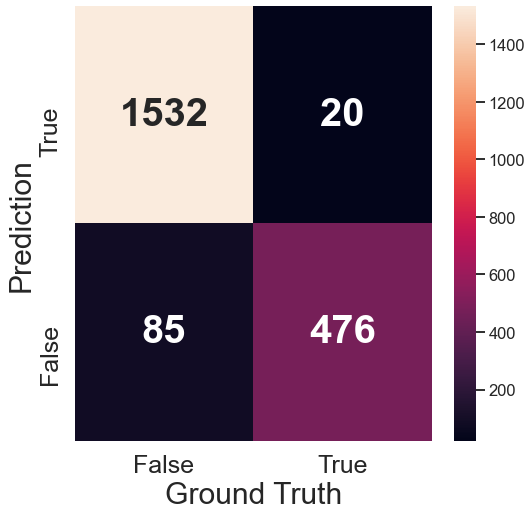

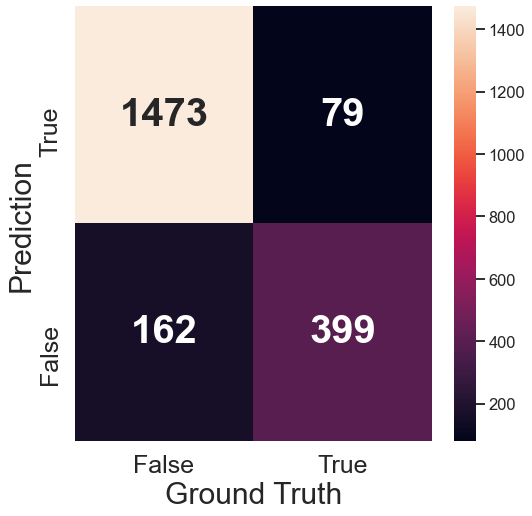

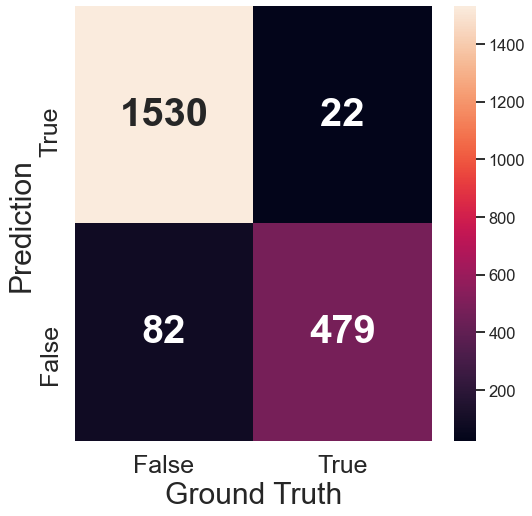

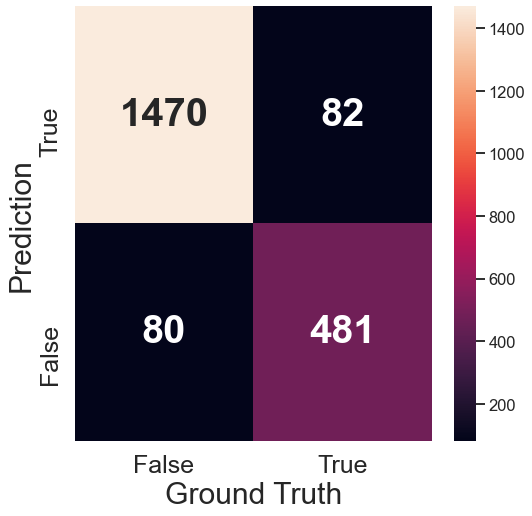

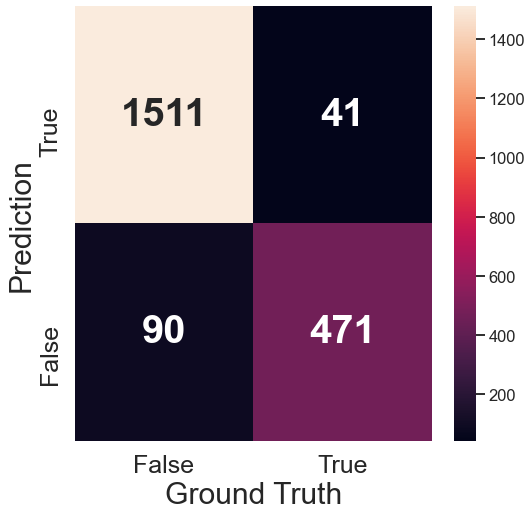

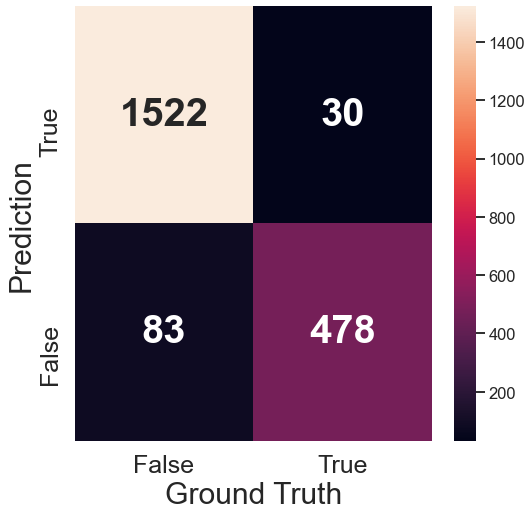

In [56]:
models = [lr, knn ,LSVC ,dt,GR, RF]

#confusion matrix
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

for model in models:
    y_pred = model.predict(X_test)
    sns.set_context('talk')
    cm = confusion_matrix(y_test, y_pred)
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(cm, annot=True, fmt='d',  annot_kws={"size": 40, "weight": "bold"})

    print("model is :", model)
    labels = ['False', 'True']
    ax.set_xticklabels(labels, fontsize=25);
    ax.set_yticklabels(labels[::-1], fontsize=25);
    ax.set_ylabel('Prediction', fontsize=30);
    ax.set_xlabel('Ground Truth', fontsize=30)
    


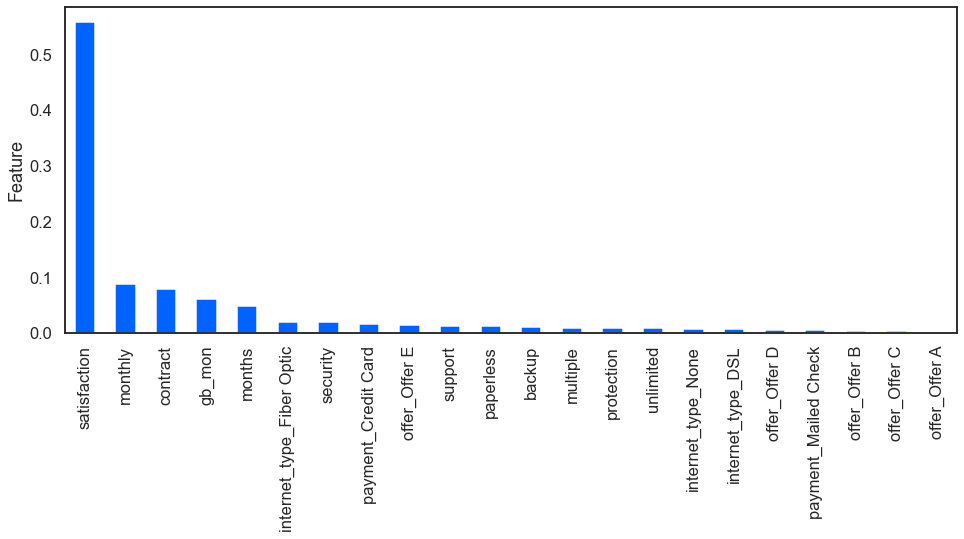

In [57]:
feature_imp = pd.Series(RF.feature_importances_, index=X.columns).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar', figsize=(16, 6))
ax.set(ylabel='Relative Importance');
ax.set(ylabel='Feature');

In [58]:
y_RF_pred = RF.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_RF_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_RF_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_RF_pred), 2))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1552
           1       0.94      0.85      0.89       561

    accuracy                           0.95      2113
   macro avg       0.94      0.92      0.93      2113
weighted avg       0.95      0.95      0.95      2113

Accuracy score:  0.95
F1 Score:  0.89


In [59]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and RAndom forest trees
estimators = [('LR', lr), ('GBC', RF)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_RF_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_RF_pred), 2))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1552
           1       0.95      0.85      0.90       561

    accuracy                           0.95      2113
   macro avg       0.95      0.92      0.93      2113
weighted avg       0.95      0.95      0.95      2113

Accuracy score:  0.95
F1 Score:  0.89


Text(0.5, 40.5, 'Ground Truth')

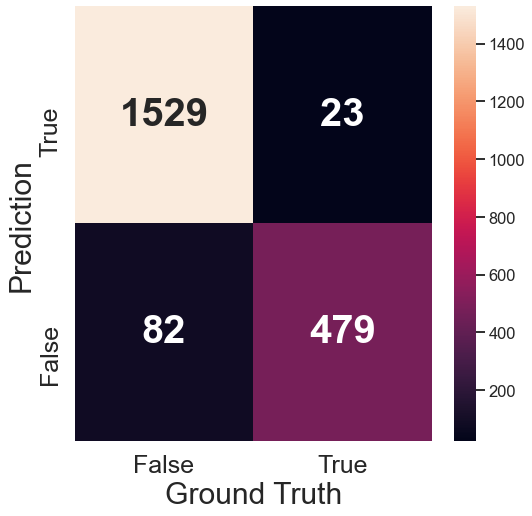

In [60]:
y_pred = VC.predict(X_test)
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
_, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(cm, annot=True, fmt='d',  annot_kws={"size": 40, "weight": "bold"})
labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

In [61]:
%%timeit
# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_lr_predict = lr.predict(X_test)

32.9 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [62]:
%%timeit
LSVC = LinearSVC()
LSVC.fit(X_train, y_train)
y_LSVC_pred = LSVC.predict(X_test)

55.5 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
